In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import Lasso
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [33]:
df = pd.read_csv('../src/data/gold/teste_indicium_precificacao_OHE.csv')
data = df.copy()
# data = data.head(50000)


In [34]:
data['media_bairro'].describe()

count    120757.000000
mean        160.805262
std          64.906561
min          51.543860
25%         113.271369
50%         149.706995
75%         203.286949
max         733.333333
Name: media_bairro, dtype: float64

# Precisamos entender nossa variável alvo e como os dados se organizam no nosso dataset

In [35]:
data.describe()

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
count,1.207570e+05,120757.00000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000,120757.000000
mean,9.424127e+07,40.72873,-73.950891,160.805262,10.742624,25.224989,1.042096,24.233560,137.745572,160.805262,0.025696,0.399604,0.443146,0.122784,0.008770,0.526222,0.451212,0.019684
std,1.242492e+08,0.05528,0.048723,265.926976,22.060538,51.748557,1.676206,124.341618,138.343199,64.906561,0.158228,0.489819,0.496759,0.328190,0.093235,0.499314,0.497616,0.138913
min,1.678000e+03,40.49979,-74.251907,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,51.543860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.229108e+06,40.68926,-73.983130,70.000000,2.000000,1.000000,0.030000,1.000000,0.000000,113.271369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.837752e+07,40.72362,-73.955430,112.000000,3.000000,5.000000,0.330000,1.000000,89.000000,149.706995,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.387706e+08,40.76302,-73.934170,185.000000,15.000000,25.000000,1.450000,3.000000,273.000000,203.286949,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,6.691812e+08,40.91306,-73.712990,20000.000000,1250.000000,2485.000000,116.300000,1154.000000,365.000000,733.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


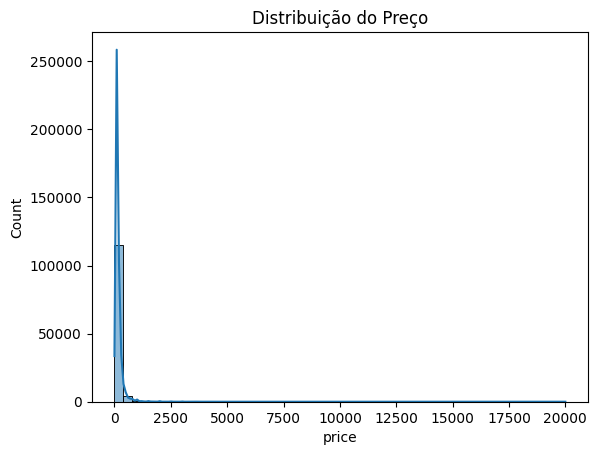

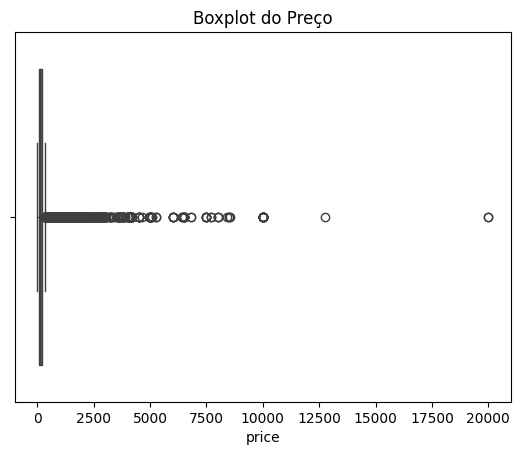

In [36]:
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Distribuição do Preço')
plt.show()

sns.boxplot(x=data['price'])
plt.title('Boxplot do Preço')
plt.show()

## A distribuição está muito irregular, com muitos dados proximos de 0

Algumas abordagens podem ser aplicadas:
* Transformação Logarítmica

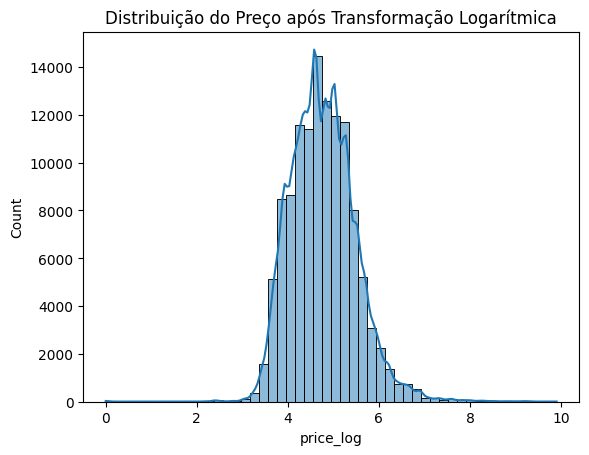

In [37]:
data['price_log'] = np.log1p(data['price'])  # log(1 + price) para evitar log(0)

# Para reverter para o valor original
# data['price_reverted'] = np.expm1(data['price_log'])

sns.histplot(data['price_log'], bins=50, kde=True)
plt.title('Distribuição do Preço após Transformação Logarítmica')
plt.show()


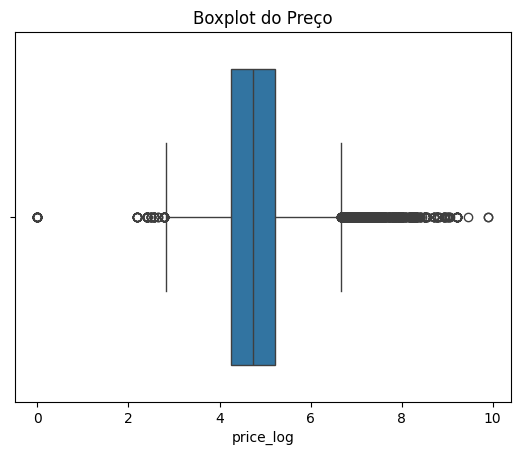

In [38]:
sns.boxplot(x=data['price_log'])
plt.title('Boxplot do Preço')
plt.show()

# Criação do modelo e testes de acurácia e precisão

In [39]:
data.head(3)

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price_log
0,2845,40.75356,-73.98559,240.0,30,49,0.27,3,365,293.581838,0,0,1,0,0,1,False,0,0,5.484797
1,15991,40.70935,-73.95342,81.0,30,195,1.03,1,196,149.706995,0,1,0,0,0,1,False,0,0,4.406719
2,16104,40.80107,-73.94255,65.0,30,1,0.03,2,83,133.278824,0,0,1,0,0,0,False,1,0,4.189655


In [40]:
data.to_csv('../src/data/gold/teste_indicium_precificacao_OHE_log.csv', index=False)

## Como nosso objetivo é 1 variável alvo numérica e de predição, utilizaremos um modelo regressor

In [41]:
x_data = data.drop(columns=['price','price_log'])
y_data = data['price_log']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)


### Regressão Lasso

In [42]:
model_Lasso = Lasso(alpha=0.1)
model_Lasso.fit(x_train, y_train)

y_pred = model_Lasso.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raiz do MSE
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 0.41
MSE: 0.31
RMSE: 0.56
R² Score: 0.39


### KNN

In [43]:
model_LGBM = lgb.LGBMRegressor(n_estimators=100)
model_LGBM.fit(x_train, y_train)

y_pred = model_LGBM.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raiz do MSE
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 84529, number of used features: 18
[LightGBM] [Info] Start training from score 4.774020
MAE: 0.32
MSE: 0.20
RMSE: 0.44
R² Score: 0.61


### Random Forest

In [44]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.20
MSE: 0.10
RMSE: 0.32
R² Score: 0.79


### XGboost

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xg_reg.fit(x_train, y_train)

y_pred = xg_reg.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.30
MSE: 0.18
RMSE: 0.42
R² Score: 0.65


# Nosso melhor modelo foi o RandomForest

In [15]:
with open("../src/models/random_forest_model_2.pkl", "wb") as f:
    pickle.dump(rf_model, f)

In [160]:
x_data

,host_id,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,2845,40.75356,-73.98559,30,49,0.27,3,365,293.581838,0,0,1,0,0,1,False,0,0
1,15991,40.70935,-73.95342,30,195,1.03,1,196,149.706995,0,1,0,0,0,1,False,0,0
2,16104,40.80107,-73.94255,30,1,0.03,2,83,133.278824,0,0,1,0,0,0,False,1,0
3,16800,40.78778,-73.94759,30,251,1.36,1,8,133.278824,0,0,1,0,0,0,False,1,0
4,17571,40.69194,-73.97389,2,395,2.17,2,261,154.367311,0,1,0,0,0,0,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120752,8232441,40.67853,-73.94995,2,0,0.00,2,9,113.271369,0,1,0,0,0,0,False,1,0
120753,6570630,40.70184,-73.93317,4,0,0.00,2,36,89.987502,0,1,0,0,0,0,False,1,0
120754,23492952,40.81475,-73.94867,10,0,0.00,1,27,125.407506,0,0,1,0,0,1,False,0,0
120755,30985759,40.75751,-73.99112,1,0,0.00,6,2,208.409054,0,0,1,0,0,0,False,0,1


In [161]:
y_data

0         5.484797
1         4.406719
2         4.189655
3         4.262680
4         5.327876
            ...   
120752    4.262680
120753    3.713572
120754    4.753590
120755    4.025352
120756    4.510860
Name: price_log, Length: 120757, dtype: float64